## 1. Import Libraries

In [1]:
import tensorflow as tf
from keras.datasets import cifar10

2024-06-13 17:04:08.623468: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Load Data

In [2]:
import keras

(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

print("Training data shape", x_train_full.shape)
print("Test data shape", x_test.shape)

Training data shape (50000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)


# 3. Visualize Data

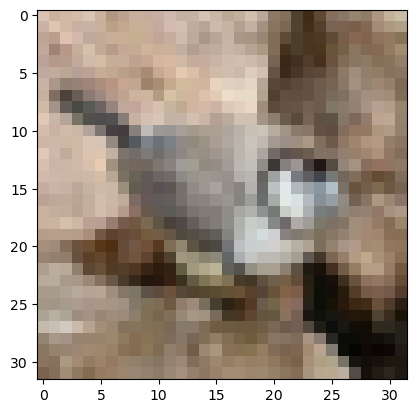

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.imshow(x_train_full[90], cmap='coolwarm')
plt.show()

# 4. Build Transfer Learning Model

## 4.1 Import Necessary Libraries

In [4]:
from keras.utils import to_categorical
from keras.applications.resnet50 import preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

## 4.2 Preprocess Input


In [5]:
x_train_full = x_train_full.astype('float32')
x_test = x_test.astype('float32')

x_train_full = preprocess_input(x_train_full)
x_test = preprocess_input(x_test)

print("Training data shape", x_train_full.shape)
print("Test data shape", x_test.shape)

Training data shape (50000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)


## 4.3 Train, Test, Split

In [6]:
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test = to_categorical(y_test, 10)

print("Training data shape", x_train.shape)
print("Test data shape", x_test.shape)
print("Valid data shape", x_valid.shape)

Training data shape (45000, 32, 32, 3)
Test data shape (10000, 32, 32, 3)
Valid data shape (5000, 32, 32, 3)


## 4.4 Define Feature Extractor and Classifier

In [7]:
def feature_extractor(inputs):
    base_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    for layer in base_model.layers:
        layer.trainable = False
        
        return base_model(inputs)

In [8]:
def classifier(inputs):
    x = GlobalAveragePooling2D()(inputs)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(10, activation='softmax', name="classification")(x)
    return x

In [9]:
def final_model(inputs):
    resize = UpSampling2D(size=(7,7))(inputs)
    resnet_fe = feature_extractor(resize)
    classification_output = classifier(resnet_fe)
    
    return classification_output

In [10]:
def compile_model():
    inputs = Input(shape=(32, 32,3))
    classification_output = final_model(inputs)
    model = Model(inputs=inputs, outputs=classification_output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

In [11]:
model = compile_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 5. Train Model

In [ ]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_valid, y_valid))

Epoch 1/5
348/704 ━━━━━━━━━━━━━━━━━━━━ 6:54:25 70s/step - accuracy: 0.5346 - loss: 1.3681